In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": 'cm',  # Computer Modern font - looks like LaTeX
    "font.family": 'STIXGeneral'
})

# $ \langle F^{\rm drag} \rangle_{T_{\rm orbit}}$ v.s. n_cell (convergence test)

20250620_tune_damping_n256_1
20250621_tune_damping_n192
20250621_tune_damping_n128


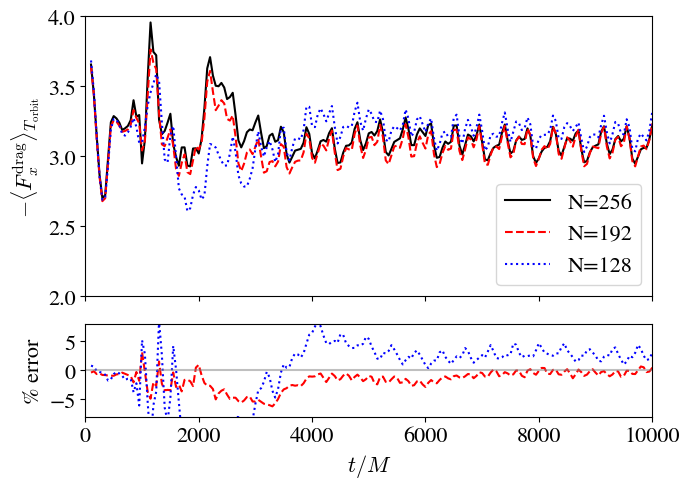

In [2]:
simnames = [ 
    # (640,'250528_BBH_r70_moreplots_restart'),
    (256, '20250620_tune_damping_n256_1'),
    (192, '20250621_tune_damping_n192'),
    (128, '20250621_tune_damping_n128')
]

plotstyles = [
    # ('-.', 'g'),
    ('-', 'k'),
    ('--', 'r'),
    (':', 'b')
]

outR=100.0
excise_factor = 1.5



binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega) 

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"


fig_fontsize = 16

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Dictionary to store data for each simulation
sim_data = {}

# First plot: drag force
for (ncell, simname), plotstyle in zip(simnames, plotstyles):
    print(simname)
    results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")

    # remove the first data points 
    results = results[1:]

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    # Create smoothed array with same length as original
    smoothed_drag = np.zeros_like(results[:,1])

    # Handle the main part where full window is available
    valid_smoothed = np.convolve(results[:,1], np.ones(window_size)/window_size, mode='valid')
    smoothed_drag[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed

    # Handle left boundary (beginning of array)
    for i in range(window_size-1):
        # Use smaller window size for boundary points
        curr_window = i + 1
        smoothed_drag[i] = np.sum(results[:curr_window,1]) / curr_window

    # Calculate normalized drag
    normalized_drag = -smoothed_drag/results_sur[:,10]
    
    # Store data for relative difference calculation
    sim_data[ncell] = {
        'time': results[:,0],
        'normalized_drag': normalized_drag
    }
    
    # Plot on the first subplot
    ax1.plot(results[:,0], normalized_drag, label=f'N={ncell}', linestyle=plotstyle[0], color=plotstyle[1])

# Second plot: relative difference compared to N=256
baseline_ncell = 256
baseline_time = sim_data[baseline_ncell]['time']
baseline_drag = sim_data[baseline_ncell]['normalized_drag']

for (ncell, _), plotstyle in zip(simnames, plotstyles):
    if ncell != baseline_ncell:
        # Create interpolation function for this simulation's data
        
        current_time = sim_data[ncell]['time']
        current_drag = sim_data[ncell]['normalized_drag']
        
        # Create interpolation function with extrapolation for out-of-bounds points
        interp_func = interp1d(current_time, current_drag, bounds_error=False, fill_value="extrapolate")
        
        # Interpolate to match baseline time points
        interpolated_drag = interp_func(baseline_time)
        
        # Calculate relative difference
        rel_diff = (interpolated_drag - baseline_drag) / baseline_drag
        
        # Plot on the second subplot
        ax2.plot(baseline_time, rel_diff*100, label=f'N={ncell}', linestyle=plotstyle[0], color=plotstyle[1])

# Configure first subplot
ax1.set_ylim(2, 4)
ax1.set_xlim(0, 10000)
ax1.set_ylabel('$-\\langle F^{\mathrm{drag}}_x \\rangle_{T_{\mathrm{orbit}}}$', fontsize=fig_fontsize)
ax1.legend(fontsize=fig_fontsize)
# set tick fontsize
ax1.tick_params(labelsize=fig_fontsize)

# Configure second subplot
ax2.set_xlabel('$t/M$', fontsize=fig_fontsize)
ax2.set_ylabel('% error', fontsize=fig_fontsize)
ax2.set_ylim(-8, 8)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax2.tick_params(axis='both', which='major', labelsize=fig_fontsize)
# ax2.legend()

# Adjust layout
plt.tight_layout()

# save as pdf
plt.savefig('n_cell_convergence.pdf', bbox_inches='tight')


# $ \langle F^{\rm drag} \rangle_{T_{\rm orbit}}$ v.s. velocity

20250622_tune_damping_n256_v04
20250620_tune_damping_n256_1
20250621_tune_damping_n256_v06
20250622_tune_damping_n256_v07


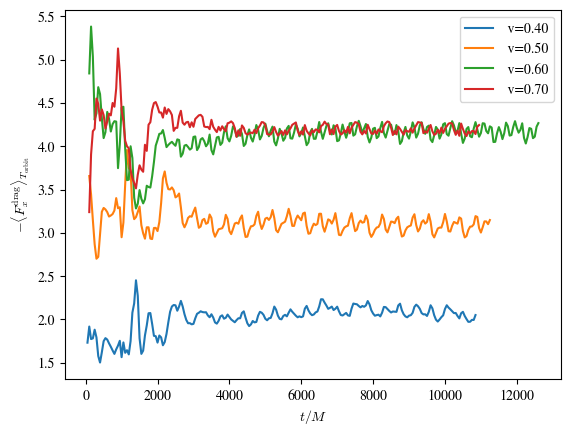

In [3]:
simnames = [ 
    (0.4, '20250622_tune_damping_n256_v04'),
    (0.5, '20250620_tune_damping_n256_1'),
    (0.6, '20250621_tune_damping_n256_v06'),
    (0.7, '20250622_tune_damping_n256_v07')
]

outR=100.0
excise_factor = 1.5



binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega)

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"



plt.figure()
for wave_vel, simname in simnames:
    print(simname)
    results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")

    # remove the first data points 
    results = results[1:]

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    # Create smoothed array with same length as original
    smoothed_drag = np.zeros_like(results[:,1])

    # Handle the main part where full window is available
    valid_smoothed = np.convolve(results[:,1], np.ones(window_size)/window_size, mode='valid')
    smoothed_drag[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed

    # Handle left boundary (beginning of array)
    for i in range(window_size-1):
        # Use smaller window size for boundary points
        curr_window = i + 1
        smoothed_drag[i] = np.sum(results[:curr_window,1]) / curr_window


    plt.plot(results[:,0], -smoothed_drag/results_sur[:,10], label=' v=%.2f'%wave_vel)

# plt.ylim(0.003,0.008)
plt.ylabel('$-\\langle F^{\mathrm{drag}}_x \\rangle_{T_{\mathrm{orbit}}}$')
plt.xlabel('$t/M$')
plt.legend()




# $ \langle \tau_z^{\rm drag} \rangle_{T_{\rm orbit}}$ v.s. velocity

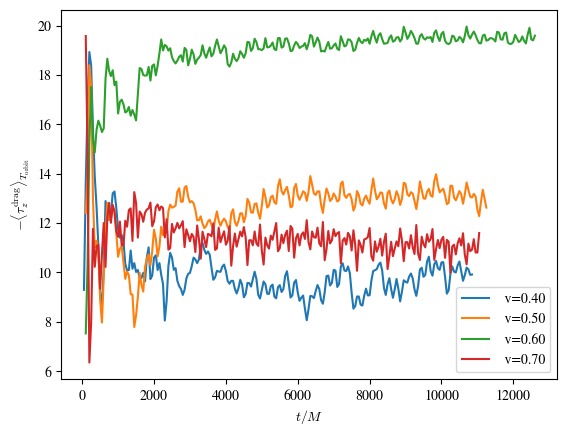

In [7]:
simnames = [ 
    # (0.3, '20250622_tune_damping_n256_v03'),
    (0.4, '20250622_tune_damping_n256_v04'),
    (0.5, '20250620_tune_damping_n256_1'),
    (0.6, '20250621_tune_damping_n256_v06'),
    (0.7, '20250622_tune_damping_n256_v07')
]

outR=320.0
excise_factor = 1.5




binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = -(70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
excise_factor = 1.5
binary_omega = - 0.002657634562418009 * 2.71811

T_orbit = np.abs(2*np.pi/binary_omega)

basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"
rundir = basedir + simname +"/"


plt.figure()
for wave_vel, simname in simnames:
    results = np.load(plotdir+f"{simname}_2d_integrals_outR{outR}_excise{excise_factor}_psipow2.0_parallel.npy")

    # remove the first data points 
    results = results[1:]

    results_sur = np.load(plotdir+f"{simname}_2d_integrals_surface_outR{outR}_excise{excise_factor}_psipow-2.0_psipow_surface_correction-2.0_parallel.npy")
    results_sur = results_sur[1:]

    dt = results[1,0] - results[0,0]

    # do a smoothed plot of results[:,1] over a window of T_orbit
    window_size = int(T_orbit/dt)

    valid_smoothed_torque = np.convolve(results[:,7], np.ones(window_size)/window_size, mode='valid')
    smoothed_torque = np.zeros_like(results[:,7])
    smoothed_torque[window_size-1:window_size-1+len(valid_smoothed_torque)] = valid_smoothed_torque
    # handle the left boundary
    for i in range(window_size-1):
        curr_window = i + 1
        smoothed_torque[i] = np.sum(results[:curr_window,7]) / curr_window


    plt.plot(results[:,0], -smoothed_torque/results_sur[:,10], label=' v=%.2f'%wave_vel)

# plt.ylim(0.003,0.008)
plt.ylabel('$-\\langle \\tau_z^{\mathrm{drag}} \\rangle_{T_{\mathrm{orbit}}}$')
plt.xlabel('$t/M$')
plt.legend()


